In [194]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud

import isodate
import ast
import re
from unidecode import unidecode

import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer




# Import necessary libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns


# Import necessary libraries for data selection
from sklearn.feature_selection import chi2

# Import library for data splitting
from sklearn.model_selection import train_test_split

# Import necessary libraries for data modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import shap

In [217]:
df = pd.read_csv('programming_org.csv', parse_dates=['fetching_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   fetching_date         5000 non-null   datetime64[ns]
 1   trending_country      5000 non-null   object        
 2   video_id              5000 non-null   object        
 3   video_title           5000 non-null   object        
 4   video_published_at    5000 non-null   object        
 5   video_description     4534 non-null   object        
 6   channel_id            5000 non-null   object        
 7   channel_title         5000 non-null   object        
 8   tags                  5000 non-null   object        
 9   category_id           5000 non-null   int64         
 10  default_language      4998 non-null   object        
 11  duration              4998 non-null   object        
 12  dimension             5000 non-null   object        
 13  definition        

In [218]:
df_last_trend = df.sort_values('fetching_date').groupby('video_id').last().reset_index()
df_last_trend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2826 entries, 0 to 2825
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   video_id              2826 non-null   object        
 1   fetching_date         2826 non-null   datetime64[ns]
 2   trending_country      2826 non-null   object        
 3   video_title           2826 non-null   object        
 4   video_published_at    2826 non-null   object        
 5   video_description     2568 non-null   object        
 6   channel_id            2826 non-null   object        
 7   channel_title         2826 non-null   object        
 8   tags                  2826 non-null   object        
 9   category_id           2826 non-null   int64         
 10  default_language      2824 non-null   object        
 11  duration              2824 non-null   object        
 12  dimension             2826 non-null   object        
 13  definition        

In [219]:
df = df_last_trend

In [198]:
df['made_for_kids'].value_counts()

made_for_kids
False    2781
True       45
Name: count, dtype: int64

In [207]:
def data_cleaning(df):
    # Remove duplicates
    hashable_cols = [col for col in df.columns if col not in ['tags', 'topic_categories']]
    df_clean = df.drop_duplicates(subset=hashable_cols)

    # Handle missing values
    key_columns = [
                    'video_id',
                    'video_title', 
                    'video_view_count', 
                    'video_like_count', 
                    'video_comment_count',
                    'video_count', 
                    'subscriber_count', 
                    'channel_view_count'
                ]
    df_clean = df_clean.dropna(subset=key_columns)

    # Remove entries with zero video_count, video_view_count, or channel_view_count
    df_clean = df_clean[(df_clean['video_count'] != 0) & (df_clean['video_view_count'] != 0) & (df_clean['channel_view_count'] != 0)]

    # Filter for English language videos
    df_clean = df_clean[df_clean['default_language'].str.startswith('en', na=False)]

    # Map category_id to category_title
    category_map = {
                    '1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'
                    }   

    # Process duration and category   
    df_clean['category_title'] = df_clean['category_id'].apply(lambda x: category_map[str(x)])
    df_clean['duration_min'] = df_clean['duration'].apply(
        lambda x: isodate.parse_duration(x).total_seconds()/60)
    df_clean['is_high_definition'] = df_clean['definition'].apply(lambda x: 1 if x == 'hd' else 0)

    # Convert date columns to datetime
    df_clean['video_published_at'] = pd.to_datetime(df_clean['video_published_at'])
    df_clean['channel_published_at'] = df_clean['channel_published_at'].apply(lambda x: re.sub(r'\.\d+Z', 'Z', str(x)))
    df_clean['channel_published_at'] = pd.to_datetime(df_clean['channel_published_at']) 
    

    return df_clean

In [206]:
def normalize_text(text):
    if pd.isna(text):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    #  Remove Web links
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def additional_normalize_text(text):
    if pd.isna(text):
        return ''
    
    # Convert accented characters to their ASCII equivalents
    text = unidecode(text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def normalize_text_columns(df, function=normalize_text):
    text_columns = ['video_title', 'video_description', 'channel_title', 'channel_description']
    for col in text_columns:
        df[col] = df[col].apply(function)
    return df

In [205]:
def sentiment_enginering(df):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_columns = ['video_title', 'video_description']
    for col in sentiment_columns:
        df[f'{col}_sentiment'] = df[col].apply(lambda x: analyzer.polarity_scores(x)["compound"])
        # df[f'has_emoji_in_{col}'] = df[col].apply(lambda x: 1 if any(char in emoji.EMOJI_DATA for char in x) else 0)
        df[f'count_of_emoji_in_{col}'] = df[col].apply(lambda x: sum(1 for char in x if char in emoji.EMOJI_DATA)) 
    return df

In [204]:
def model_feature_engineering(df):

    df['publishing_day'] = df['video_published_at'].apply(lambda x: pd.to_datetime(x).day_name())
    df['publishing_hour'] = df['video_published_at'].apply(lambda x: pd.to_datetime(x).hour)
    
    df['video_age_days'] = (pd.to_datetime(df['fetching_date'], utc=True) - pd.to_datetime(df['video_published_at'])).dt.total_seconds() / (24 * 3600)  
    df['channel_age_days'] = (pd.to_datetime(df['fetching_date'], utc=True) - pd.to_datetime(df['channel_published_at'])).dt.total_seconds() / (24 * 3600)  

    # df['has_tags'] = df['tags'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '[]' else 1)
    df['counts_of_tags'] = df['tags'].apply(lambda x: 0 if pd.isna(x) else len(ast.literal_eval(x)))
    # df['has_topic_categories'] = df['topic_categories'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)
    # df['counts_of_topic_categories'] = df['topic_categories'].apply(lambda x: 0 if pd.isna(x) else len(ast.literal_eval(x)))
    # df['has_video_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)
    # df['has_channel_description'] = df['channel_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else 1)    
    df['word_count_in_title'] = df['video_title'].apply(lambda x: len(x.split()))
    df['word_count_in_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))
    df['word_count_in_channel_title'] = df['channel_title'].apply(lambda x: len(x.split())) 
    df['word_count_in_channel_description'] = df['channel_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x.split()))
    # df['character_count_in_title'] = df['video_title'].apply(lambda x: len(x))
    # df['character_count_in_description'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else len(x))
    

    # df['title_sentiment_blob'] = df['video_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    # df['description_sentiment_blob'] = df['video_description'].apply(lambda x: 0 if pd.isna(x) or x.strip() == '' else TextBlob(x).sentiment.polarity)

    return df


In [221]:
df.isnull().sum()
df = df.dropna(subset=['duration'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2824 entries, 0 to 2825
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   video_id              2824 non-null   object        
 1   fetching_date         2824 non-null   datetime64[ns]
 2   trending_country      2824 non-null   object        
 3   video_title           2824 non-null   object        
 4   video_published_at    2824 non-null   object        
 5   video_description     2566 non-null   object        
 6   channel_id            2824 non-null   object        
 7   channel_title         2824 non-null   object        
 8   tags                  2824 non-null   object        
 9   category_id           2824 non-null   int64         
 10  default_language      2822 non-null   object        
 11  duration              2824 non-null   object        
 12  dimension             2824 non-null   object        
 13  definition            2

In [222]:
df = data_cleaning(df)
df = normalize_text_columns(df, function=normalize_text)
df = sentiment_enginering(df)
df = normalize_text_columns(df, function=additional_normalize_text)
dfoo = df.copy()
df = model_feature_engineering(df)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2394 entries, 0 to 2825
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   video_id                             2394 non-null   object             
 1   fetching_date                        2394 non-null   datetime64[ns]     
 2   trending_country                     2394 non-null   object             
 3   video_title                          2394 non-null   object             
 4   video_published_at                   2394 non-null   datetime64[ns, UTC]
 5   video_description                    2394 non-null   object             
 6   channel_id                           2394 non-null   object             
 7   channel_title                        2394 non-null   object             
 8   tags                                 2394 non-null   object             
 9   category_id                        

In [223]:
df = df[df['duration_min'] <1]
dfo = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 2819
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   video_id                             860 non-null    object             
 1   fetching_date                        860 non-null    datetime64[ns]     
 2   trending_country                     860 non-null    object             
 3   video_title                          860 non-null    object             
 4   video_published_at                   860 non-null    datetime64[ns, UTC]
 5   video_description                    860 non-null    object             
 6   channel_id                           860 non-null    object             
 7   channel_title                        860 non-null    object             
 8   tags                                 860 non-null    object             
 9   category_id                         

In [224]:
def data_encoding(df):
    # One-hot encode categorical variables
    one_hot_columns = ['category_title', 'publishing_day', 'publishing_hour']
    df = pd.get_dummies(df, columns=one_hot_columns, drop_first=False)

    return df

In [225]:
df = data_encoding(df)
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 2819
Data columns (total 71 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   video_id                             860 non-null    object             
 1   fetching_date                        860 non-null    datetime64[ns]     
 2   trending_country                     860 non-null    object             
 3   video_title                          860 non-null    object             
 4   video_published_at                   860 non-null    datetime64[ns, UTC]
 5   video_description                    860 non-null    object             
 6   channel_id                           860 non-null    object             
 7   channel_title                        860 non-null    object             
 8   tags                                 860 non-null    object             
 9   category_id                         

EDA

<Axes: >

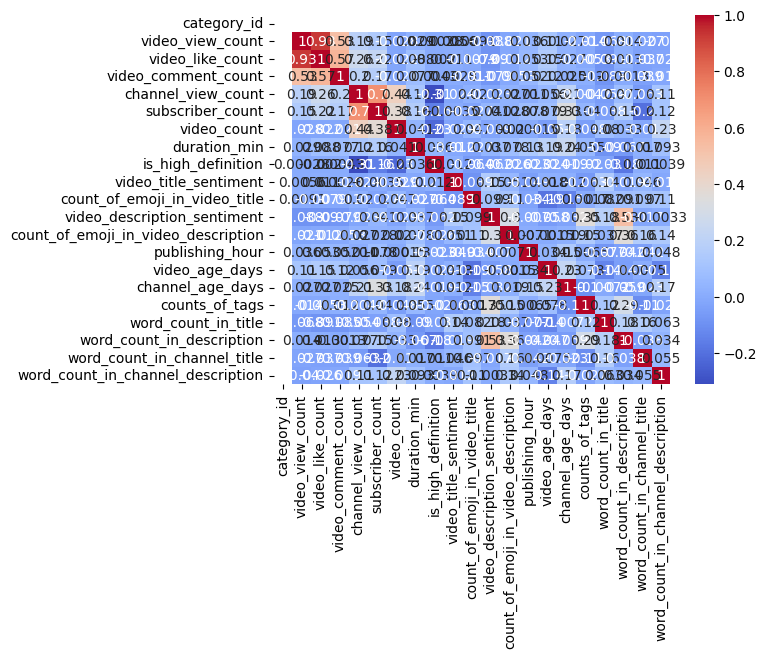

In [226]:
# heatmap for correlation
numeric_cols = dfo.select_dtypes(include='number').columns.tolist()
categorical_cols = dfo.select_dtypes(include=['object', 'category']).columns.tolist()

sns.heatmap(dfo[numeric_cols].corr(), annot=True, cmap='coolwarm')



In [147]:
# # heatmap for correlation
# numeric_cols = df.select_dtypes(include='number').columns.tolist()
# categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# sns.heatmap(df[numeric_cols].corr(), annot=False, cmap='coolwarm')



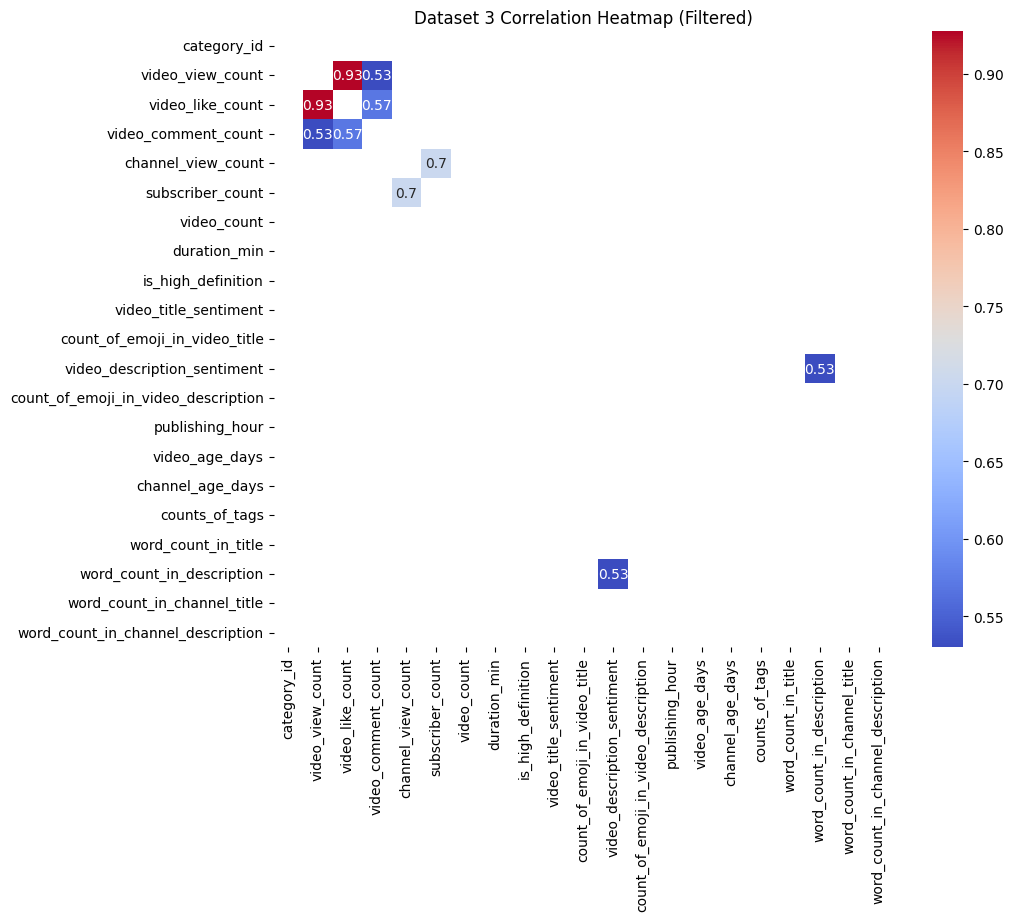

In [228]:
filtered_heatmap = dfo[numeric_cols].corr().abs()
filtered_heatmap = (filtered_heatmap > 0.5) & (filtered_heatmap < 1.0)
plt.figure(figsize=(10, 8))
sns.heatmap(dfo[numeric_cols].corr(), annot=True, cmap='coolwarm', mask=~filtered_heatmap)
plt.title('Dataset 3 Correlation Heatmap (Filtered)')
plt.show()  

In [237]:
df.describe()

,fetching_date,category_id,licensed_content,video_view_count,video_like_count,video_comment_count,made_for_kids,channel_view_count,subscriber_count,video_count,...,publishing_hour_14,publishing_hour_15,publishing_hour_16,publishing_hour_17,publishing_hour_18,publishing_hour_19,publishing_hour_20,publishing_hour_21,publishing_hour_22,publishing_hour_23
count,860,860.0,860.000000,8.600000e+02,8.600000e+02,860.000000,860.000000,8.600000e+02,8.600000e+02,860.000000,...,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000
mean,2025-10-18 15:20:18.501705728,27.0,0.572093,7.390505e+05,2.896144e+04,248.062791,0.004651,1.663473e+08,1.094234e+06,1925.740698,...,0.090698,0.075581,0.074419,0.038372,0.027907,0.016279,0.022093,0.023256,0.008140,0.005814
min,2025-10-16 21:53:13.108236,27.0,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,7.400000e+01,0.000000e+00,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2025-10-16 22:07:36.999279104,27.0,0.000000,9.886500e+03,1.912500e+02,3.000000,0.000000,8.670262e+05,3.800000e+03,125.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2025-10-19 02:47:30.885148928,27.0,1.000000,8.971150e+04,2.325500e+03,26.000000,0.000000,9.147081e+06,5.170000e+04,523.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2025-10-19 02:47:30.885148928,27.0,1.000000,4.510745e+05,1.225850e+04,106.000000,0.000000,6.355125e+07,3.740000e+05,1423.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2025-10-19 14:59:36.700604,27.0,1.000000,5.691148e+07,2.696282e+06,36368.000000,1.000000,7.537686e+09,2.040000e+07,61154.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.0,0.495063,3.256459e+06,1.396000e+05,1461.555160,0.068080,5.591465e+08,2.772251e+06,6068.083124,...,0.287346,0.264481,0.262604,0.192205,0.164802,0.126620,0.147072,0.150803,0.089904,0.076072


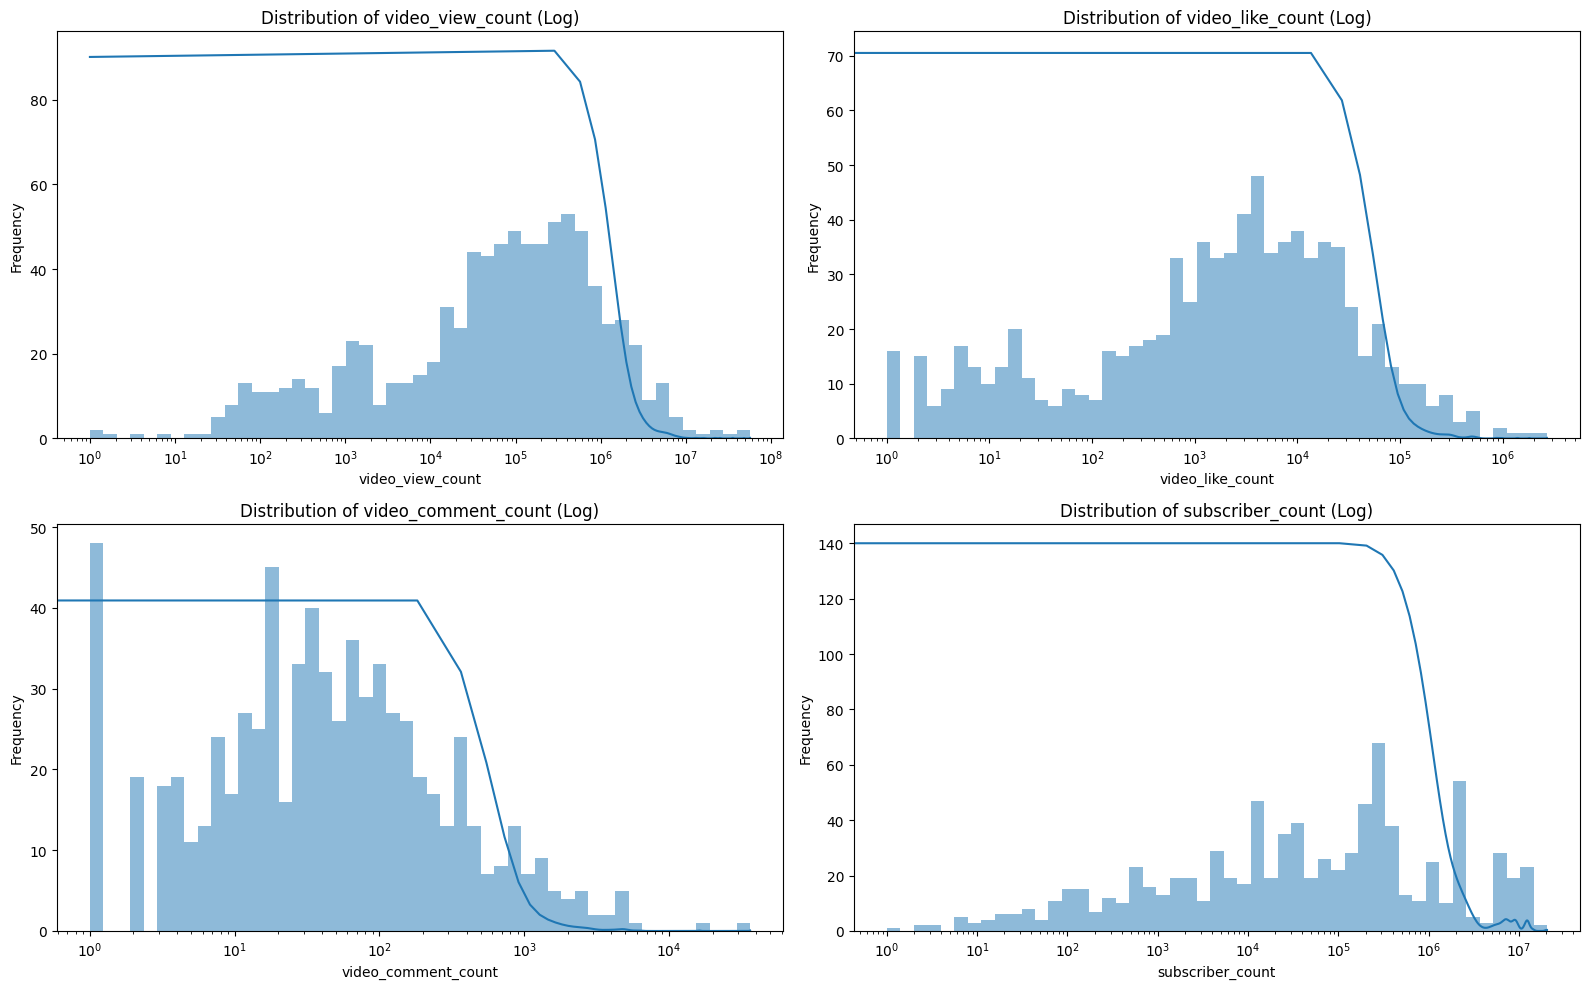

In [236]:
cols = ['video_view_count', 'video_like_count', 'video_comment_count', 'subscriber_count']

# Set up the figure
plt.figure(figsize=(16, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    
    # Logarithmic binning
    bins = np.logspace(0, np.log10(df[col].max()+1), 50)  # add 1 to avoid log(0)
    
    sns.histplot(df[col], bins=bins, kde=True)
    plt.xscale('log')
    plt.title(f'Distribution of {col} (Log)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



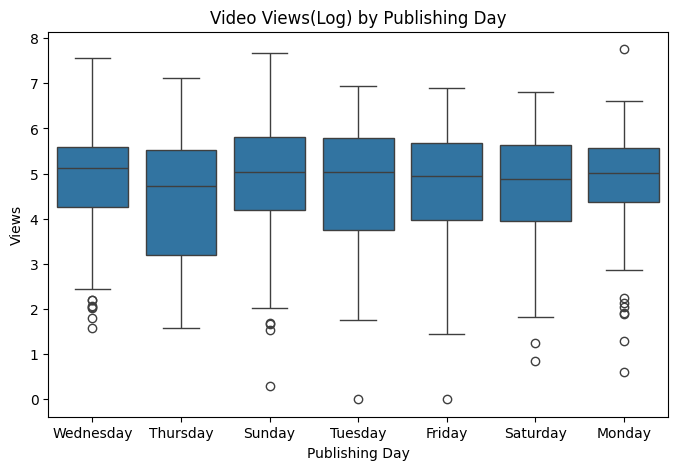

In [239]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log10(dfo['video_view_count']), data=dfo)
plt.title("Video Views(Log) by Publishing Day")
plt.ylabel("Views")
plt.xlabel("Publishing Day")
plt.show()

/Users/meilan/neuMSDAE/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


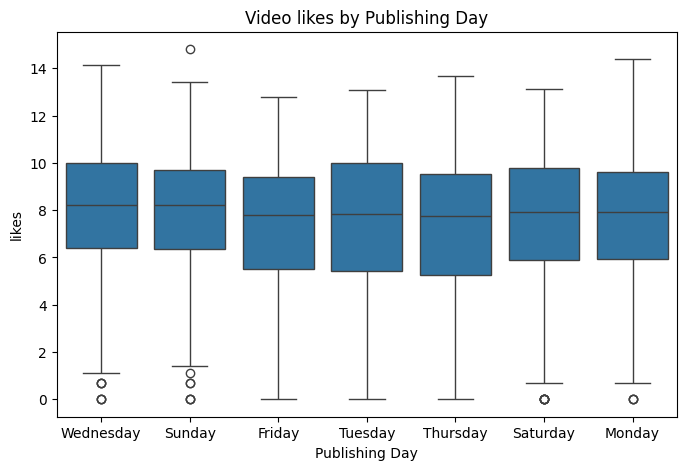

In [151]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log(dfo['video_like_count']), data=dfo)
plt.title("Video likes by Publishing Day")
plt.ylabel("likes")
plt.xlabel("Publishing Day")
plt.show()

/Users/meilan/neuMSDAE/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


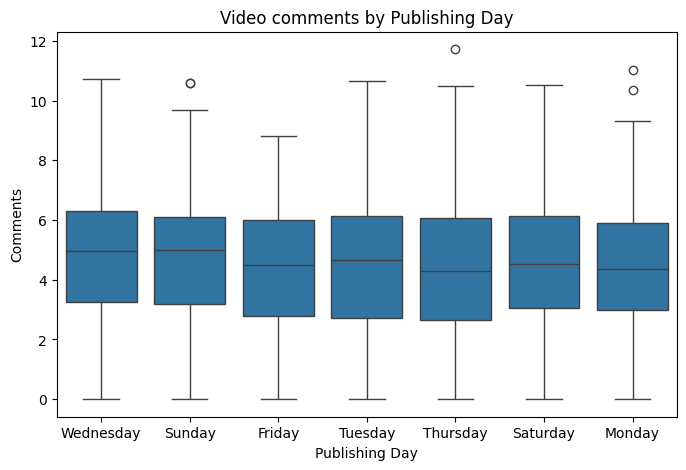

In [152]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_day', y=np.log(dfo['video_comment_count']), data=dfo)
plt.title("Video comments by Publishing Day")
plt.ylabel("Comments")
plt.xlabel("Publishing Day")
plt.show()

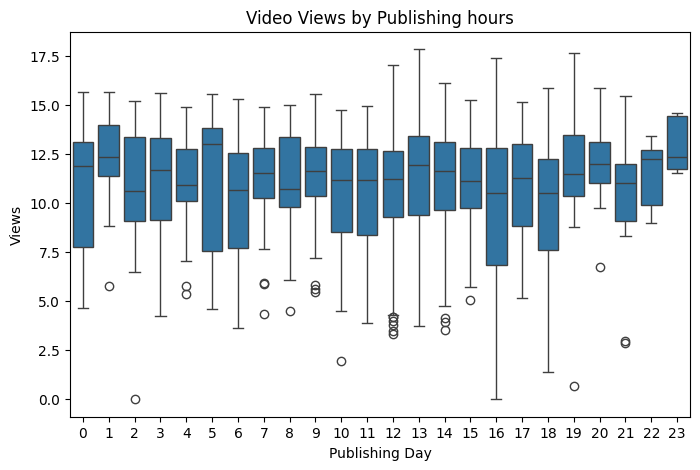

In [382]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_view_count']), data=dfo)
plt.title("Video Views by Publishing hours")
plt.ylabel("Views")
plt.xlabel("Publishing Day")
plt.show()

/Users/meilan/neuMSDAE/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


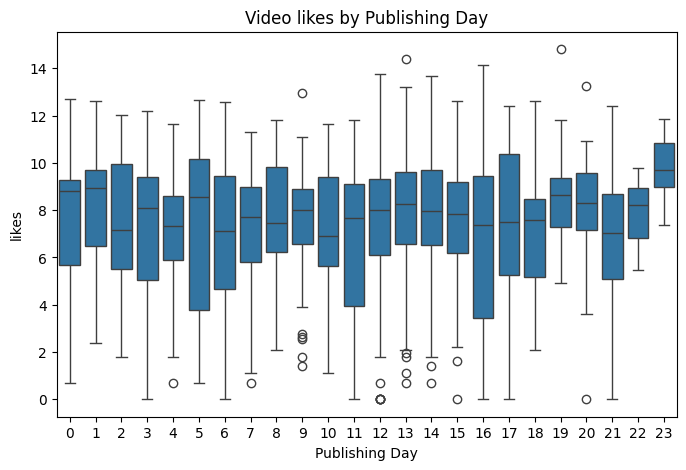

In [241]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_like_count']), data=dfo)
plt.title("Video likes by Publishing Day")
plt.ylabel("likes")
plt.xlabel("Publishing Day")
plt.show()

/Users/meilan/neuMSDAE/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


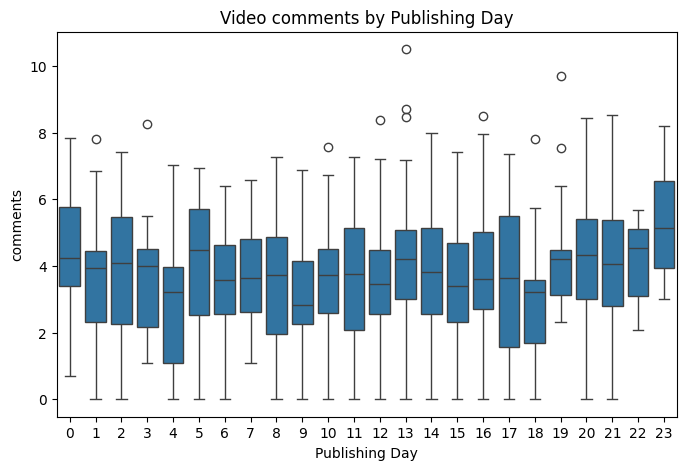

In [242]:
plt.figure(figsize=(8,5))
sns.boxplot(x='publishing_hour', y=np.log(dfo['video_comment_count']), data=dfo)
plt.title("Video comments by Publishing Day")
plt.ylabel("comments")
plt.xlabel("Publishing Day")
plt.show()

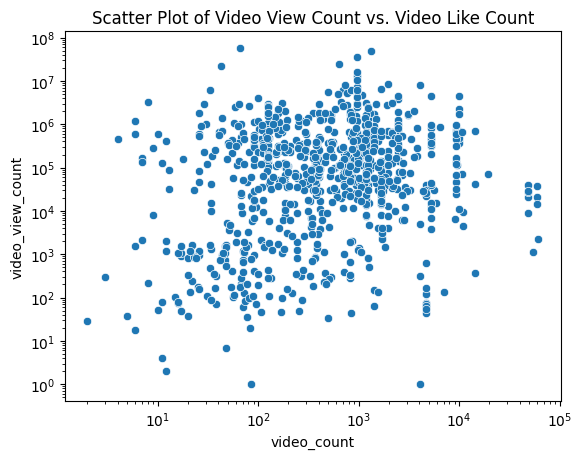

In [360]:
sns.scatterplot(y='video_view_count', x='video_count', data=df)
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('Video View Count (log scale)')
# plt.ylabel('Video Like Count (log scale)')
plt.title('Scatter Plot of Video View Count vs. Video Like Count')
plt.show()


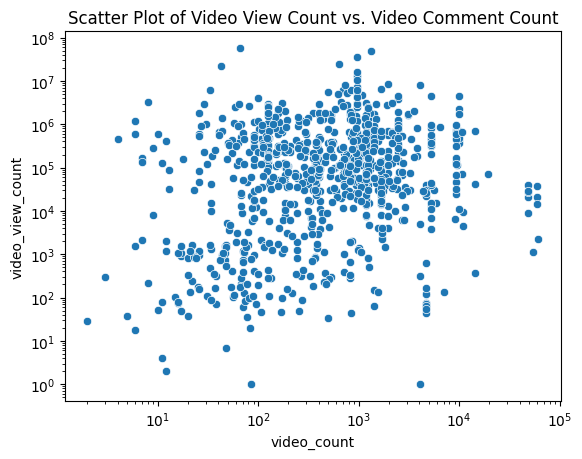

In [278]:
sns.scatterplot(y='video_view_count', x='video_count', data=dfo)
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('Video View Count (log scale)')
# plt.ylabel('Video Comment Count (log scale)')
plt.title('Scatter Plot of Video View Count vs. Video Comment Count')
plt.show()               

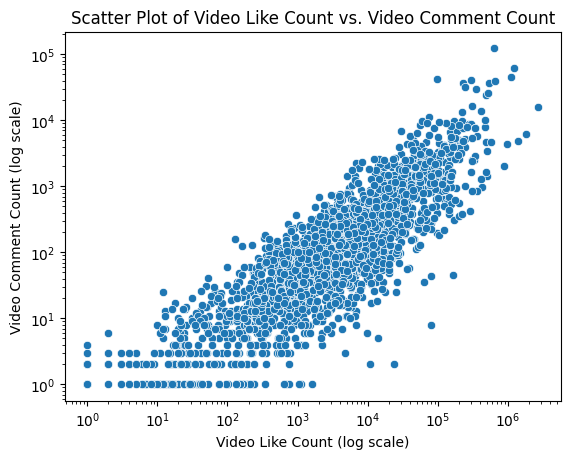

In [158]:
sns.scatterplot(x='video_like_count', y='video_comment_count', data=dfo)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Video Like Count (log scale)')
plt.ylabel('Video Comment Count (log scale)')
plt.title('Scatter Plot of Video Like Count vs. Video Comment Count')
plt.show()




In [245]:
threshold = df['video_view_count'].quantile(0.50)
top_videos = df[df['video_view_count'] >= threshold]
top_videos.describe()

,fetching_date,category_id,licensed_content,video_view_count,video_like_count,video_comment_count,made_for_kids,channel_view_count,subscriber_count,video_count,...,publishing_hour_14,publishing_hour_15,publishing_hour_16,publishing_hour_17,publishing_hour_18,publishing_hour_19,publishing_hour_20,publishing_hour_21,publishing_hour_22,publishing_hour_23
count,430,430.0,430.000000,4.300000e+02,4.300000e+02,430.000000,430.000000,4.300000e+02,4.300000e+02,430.000000,...,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,2025-10-18 19:07:04.046524160,27.0,0.658140,1.456643e+06,5.724980e+04,483.306977,0.006977,2.369815e+08,1.496777e+06,1346.444186,...,0.097674,0.062791,0.060465,0.037209,0.023256,0.018605,0.030233,0.018605,0.009302,0.011628
min,2025-10-16 21:53:13.108236,27.0,0.000000,8.974000e+04,5.330000e+02,0.000000,0.000000,1.320990e+05,1.170000e+02,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2025-10-19 02:47:30.885148928,27.0,0.000000,2.154025e+05,4.917500e+03,44.000000,0.000000,3.352138e+06,1.452500e+04,153.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2025-10-19 02:47:30.885148928,27.0,1.000000,4.513540e+05,1.229200e+04,99.000000,0.000000,2.934616e+07,1.590000e+05,649.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2025-10-19 14:59:36.700603904,27.0,1.000000,1.114003e+06,3.387375e+04,312.500000,0.000000,1.314040e+08,9.425000e+05,1247.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2025-10-19 14:59:36.700604,27.0,1.000000,5.691148e+07,2.696282e+06,36368.000000,1.000000,6.915927e+09,2.040000e+07,14351.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.0,0.474886,4.494538e+06,1.934335e+05,2041.019520,0.083332,6.124291e+08,3.105262e+06,2223.362354,...,0.297220,0.242869,0.238624,0.189495,0.150890,0.135281,0.171426,0.135281,0.096111,0.107329


In [159]:
dfo.columns

Index(['video_id', 'fetching_date', 'trending_country', 'video_title',
       'video_published_at', 'video_description', 'channel_id',
       'channel_title', 'tags', 'category_id', 'default_language', 'duration',
       'dimension', 'definition', 'licensed_content', 'video_view_count',
       'video_like_count', 'video_comment_count', 'topic_categories',
       'made_for_kids', 'channel_published_at', 'channel_description',
       'channel_country', 'channel_view_count', 'subscriber_count',
       'video_count', 'category_title', 'duration_min', 'is_high_definition',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'publishing_day', 'publishing_hour', 'video_age_days',
       'channel_age_days', 'counts_of_tags', 'word_count_in_title',
       'word_count_in_description', 'word_count_in_channel_title',
       'word_count_in_channel_description'],
      dtype='object')

In [160]:
dfo.columns

Index(['video_id', 'fetching_date', 'trending_country', 'video_title',
       'video_published_at', 'video_description', 'channel_id',
       'channel_title', 'tags', 'category_id', 'default_language', 'duration',
       'dimension', 'definition', 'licensed_content', 'video_view_count',
       'video_like_count', 'video_comment_count', 'topic_categories',
       'made_for_kids', 'channel_published_at', 'channel_description',
       'channel_country', 'channel_view_count', 'subscriber_count',
       'video_count', 'category_title', 'duration_min', 'is_high_definition',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'publishing_day', 'publishing_hour', 'video_age_days',
       'channel_age_days', 'counts_of_tags', 'word_count_in_title',
       'word_count_in_description', 'word_count_in_channel_title',
       'word_count_in_channel_description'],
      dtype='object')

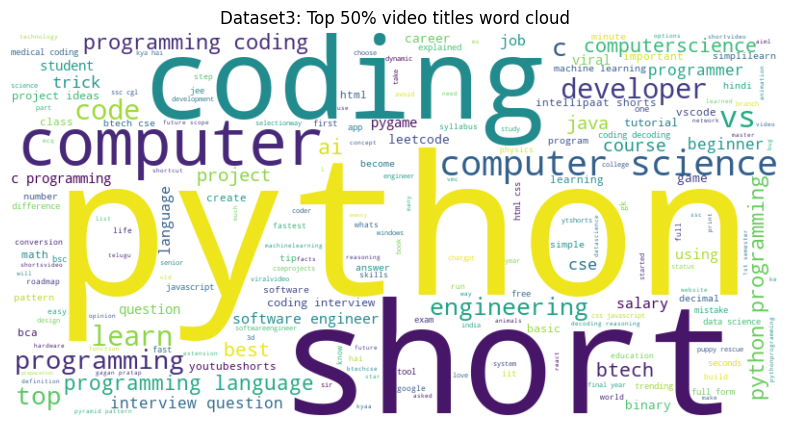

In [246]:
text = ' '.join(top_videos['video_title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.title('Dataset3: Top 50% video titles word cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

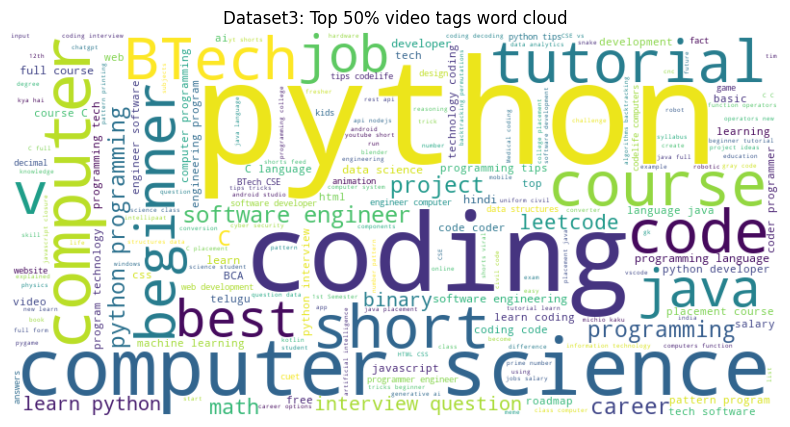

In [248]:
all_tags = ' '.join(top_videos['tags'].dropna().apply(lambda x: ' '.join(ast.literal_eval(x))))
wordcloud_tags = WordCloud(width=800, height=400, background_color='white').generate(all_tags)
plt.figure(figsize=(10, 5))
plt.title('Dataset3: Top 50% video tags word cloud')
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis('off')
plt.show()

In [164]:
df.columns

Index(['video_id', 'fetching_date', 'trending_country', 'video_title',
       'video_published_at', 'video_description', 'channel_id',
       'channel_title', 'tags', 'category_id', 'default_language', 'duration',
       'dimension', 'definition', 'licensed_content', 'video_view_count',
       'video_like_count', 'video_comment_count', 'topic_categories',
       'made_for_kids', 'channel_published_at', 'channel_description',
       'channel_country', 'channel_view_count', 'subscriber_count',
       'video_count', 'duration_min', 'is_high_definition',
       'video_title_sentiment', 'count_of_emoji_in_video_title',
       'video_description_sentiment', 'count_of_emoji_in_video_description',
       'video_age_days', 'channel_age_days', 'counts_of_tags',
       'word_count_in_title', 'word_count_in_description',
       'word_count_in_channel_title', 'word_count_in_channel_description',
       'category_title_Education', 'publishing_day_Friday',
       'publishing_day_Monday', 'publishing_

In [249]:
df['is_high_definition'].value_counts()

is_high_definition
1    858
0      2
Name: count, dtype: int64

In [367]:
df_model = df[[
 
 'licensed_content',
 'video_view_count',
 'video_like_count',
 'video_comment_count',
 'channel_view_count',
 'subscriber_count',
 'video_count',
 'duration_min',
 'is_high_definition',

 'counts_of_tags',
 'video_title_sentiment',
 'count_of_emoji_in_video_title',
 'video_description_sentiment',
 'count_of_emoji_in_video_description',
 'video_age_days',
 'channel_age_days',
 
 
 'word_count_in_title',
 'word_count_in_description',
 'word_count_in_channel_title',
 'word_count_in_channel_description',
 

      'publishing_day_Monday',
      'publishing_day_Saturday',
      'publishing_day_Sunday',
      'publishing_day_Thursday',
      'publishing_day_Tuesday',
      'publishing_day_Wednesday',
      'publishing_hour_0',
      'publishing_hour_1',
      'publishing_hour_2',
      'publishing_hour_3',
      'publishing_hour_4',
      'publishing_hour_5',
      'publishing_hour_6',
      'publishing_hour_7',
      'publishing_hour_8',
      'publishing_hour_9',
      'publishing_hour_10',
      'publishing_hour_11',
      'publishing_hour_12',
      'publishing_hour_13',
      'publishing_hour_14',
      'publishing_hour_15',
      'publishing_hour_16',
      'publishing_hour_17',
      'publishing_hour_18',
      'publishing_hour_19',
      'publishing_hour_20',
      'publishing_hour_21',
      'publishing_hour_22',
      'publishing_hour_23',
 ]]

len(df_model.columns)

50

In [368]:
output_cols =[
 'video_view_count',
 'video_like_count',
 'video_comment_count',
 'channel_view_count',
 'subscriber_count']

In [369]:
df_output = df[output_cols]
df_output['engaging_count']= df['video_like_count'] + df['video_comment_count']
df_output.info()


<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 2819
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_view_count     860 non-null    float64
 1   video_like_count     860 non-null    float64
 2   video_comment_count  860 non-null    float64
 3   channel_view_count   860 non-null    int64  
 4   subscriber_count     860 non-null    int64  
 5   engaging_count       860 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 47.0 KB


/var/folders/kg/0rnyb9h57zjgz1rz383bzj380000gn/T/ipykernel_27858/2695098275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['engaging_count']= df['video_like_count'] + df['video_comment_count']


In [257]:
df_model.describe()

,licensed_content,video_view_count,video_like_count,video_comment_count,channel_view_count,subscriber_count,video_count,duration_min,is_high_definition,counts_of_tags,...,publishing_hour_14,publishing_hour_15,publishing_hour_16,publishing_hour_17,publishing_hour_18,publishing_hour_19,publishing_hour_20,publishing_hour_21,publishing_hour_22,publishing_hour_23
count,860.000000,8.600000e+02,8.600000e+02,860.000000,8.600000e+02,8.600000e+02,860.000000,860.000000,860.000000,860.000000,...,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000
mean,0.572093,7.390505e+05,2.896144e+04,248.062791,1.663473e+08,1.094234e+06,1925.740698,0.561085,0.997674,8.962791,...,0.090698,0.075581,0.074419,0.038372,0.027907,0.016279,0.022093,0.023256,0.008140,0.005814
std,0.495063,3.256459e+06,1.396000e+05,1461.555160,5.591465e+08,2.772251e+06,6068.083124,0.286358,0.048196,10.905713,...,0.287346,0.264481,0.262604,0.192205,0.164802,0.126620,0.147072,0.150803,0.089904,0.076072
min,0.000000,1.000000e+00,0.000000e+00,0.000000,7.400000e+01,0.000000e+00,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.886500e+03,1.912500e+02,3.000000,8.670262e+05,3.800000e+03,125.000000,0.283333,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,8.971150e+04,2.325500e+03,26.000000,9.147081e+06,5.170000e+04,523.000000,0.566667,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.510745e+05,1.225850e+04,106.000000,6.355125e+07,3.740000e+05,1423.000000,0.833333,1.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,5.691148e+07,2.696282e+06,36368.000000,7.537686e+09,2.040000e+07,61154.000000,0.983333,1.000000,47.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [370]:
df_model = df_model.drop(columns=output_cols)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 2819
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   licensed_content                     860 non-null    int64  
 1   video_count                          860 non-null    int64  
 2   duration_min                         860 non-null    float64
 3   is_high_definition                   860 non-null    int64  
 4   counts_of_tags                       860 non-null    int64  
 5   video_title_sentiment                860 non-null    float64
 6   count_of_emoji_in_video_title        860 non-null    int64  
 7   video_description_sentiment          860 non-null    float64
 8   count_of_emoji_in_video_description  860 non-null    int64  
 9   video_age_days                       860 non-null    float64
 10  channel_age_days                     860 non-null    float64
 11  word_count_in_title                 

In [371]:
X = df_model
y = df_output['video_view_count'].apply(lambda x: np.log10(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [ ]:
# Define a functio to train the model and display metric evaluations
def train_model(model, X_train=X_train, y_train=y_train):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    r2 = r2_score(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mse) 

    print(f'R^2: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
   

In [373]:
random_forest_model_view = RandomForestRegressor(random_state=9)
random_forest_model_view

RandomForestRegressor(random_state=9)

In [374]:
# train the model
train_model(model=random_forest_model_view, X_train=X_train, y_train=y_train)

R^2: 0.5390220931452114
MAE: 0.6180419431193264
MSE: 0.7633682117437467
RMSE: 0.8737094549927605


/var/folders/kg/0rnyb9h57zjgz1rz383bzj380000gn/T/ipykernel_27858/3938411791.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10), palette='viridis' )


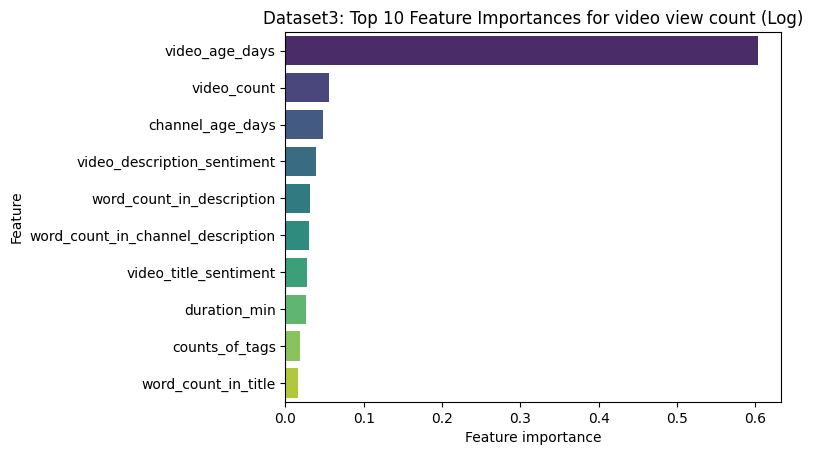

In [ ]:
feature_importance = random_forest_model_view.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Feature importance': feature_importance
})


feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10), palette='viridis' )
plt.title('Dataset3: Top 10 Feature Importances for video view count (Log)')
plt.show()  

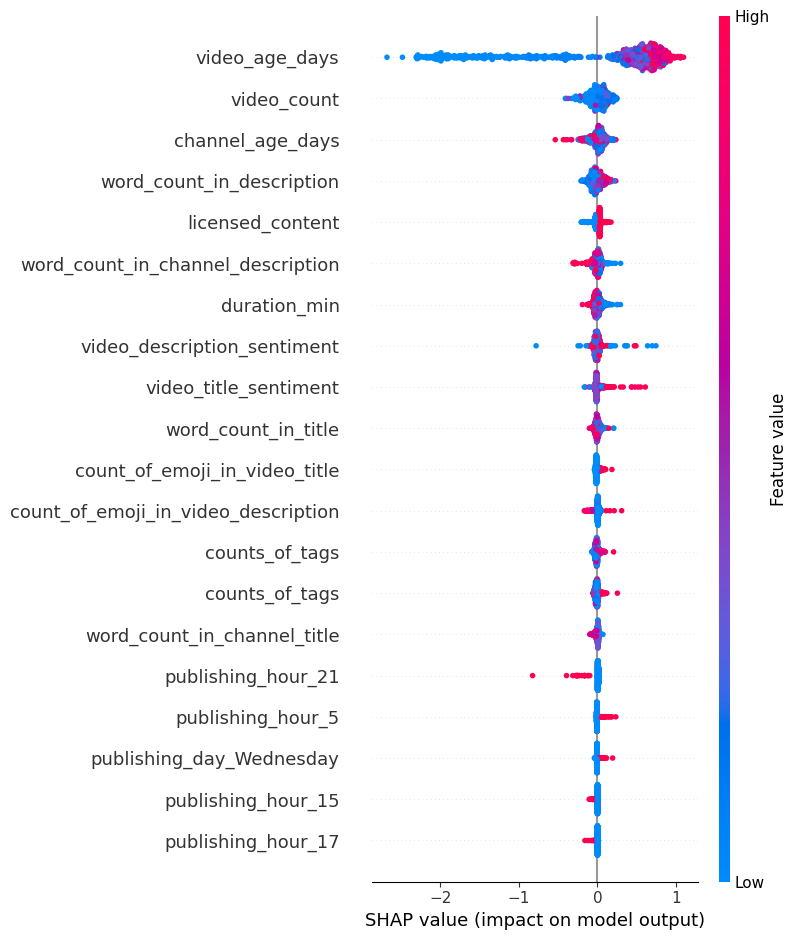

In [267]:
explainer = shap.Explainer(random_forest_model_view, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)      


In [385]:
df_model.columns

Index(['licensed_content', 'video_count', 'duration_min', 'is_high_definition',
       'counts_of_tags', 'video_title_sentiment',
       'count_of_emoji_in_video_title', 'video_description_sentiment',
       'count_of_emoji_in_video_description', 'video_age_days',
       'channel_age_days', 'word_count_in_title', 'word_count_in_description',
       'word_count_in_channel_title', 'word_count_in_channel_description',
       'publishing_day_Monday', 'publishing_day_Saturday',
       'publishing_day_Sunday', 'publishing_day_Thursday',
       'publishing_day_Tuesday', 'publishing_day_Wednesday',
       'publishing_hour_0', 'publishing_hour_1', 'publishing_hour_2',
       'publishing_hour_3', 'publishing_hour_4', 'publishing_hour_5',
       'publishing_hour_6', 'publishing_hour_7', 'publishing_hour_8',
       'publishing_hour_9', 'publishing_hour_10', 'publishing_hour_11',
       'publishing_hour_12', 'publishing_hour_13', 'publishing_hour_14',
       'publishing_hour_15', 'publishing_hour_1

In [291]:
X = df_model
y = df_output['engaging_count'].apply(lambda x: np.log1p(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [292]:

random_forest_model_engaging = RandomForestRegressor(random_state=9)
random_forest_model_engaging

RandomForestRegressor(random_state=9)

In [ ]:
train_model(model=random_forest_model_engaging, X_train=X_train, y_train=y_train)

R^2: 0.5851037231053813
MAE: 1.4588723340667047
MSE: 4.082259638545581
RMSE: 2.0204602541365624


/var/folders/kg/0rnyb9h57zjgz1rz383bzj380000gn/T/ipykernel_27858/235475409.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10), palette='viridis' )


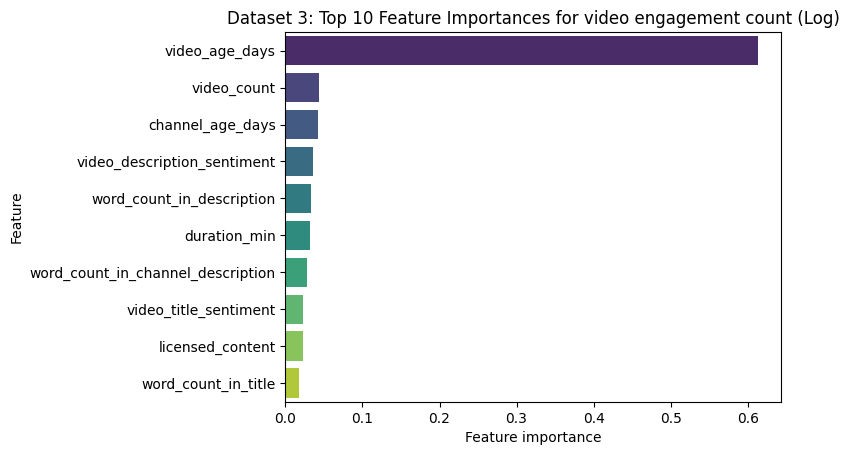

In [ ]:
feature_importance = random_forest_model_engaging.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Feature importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10), palette='viridis' )
plt.title('Dataset 3: Top 10 Feature Importances for video engagement count (Log)')
plt.show()  

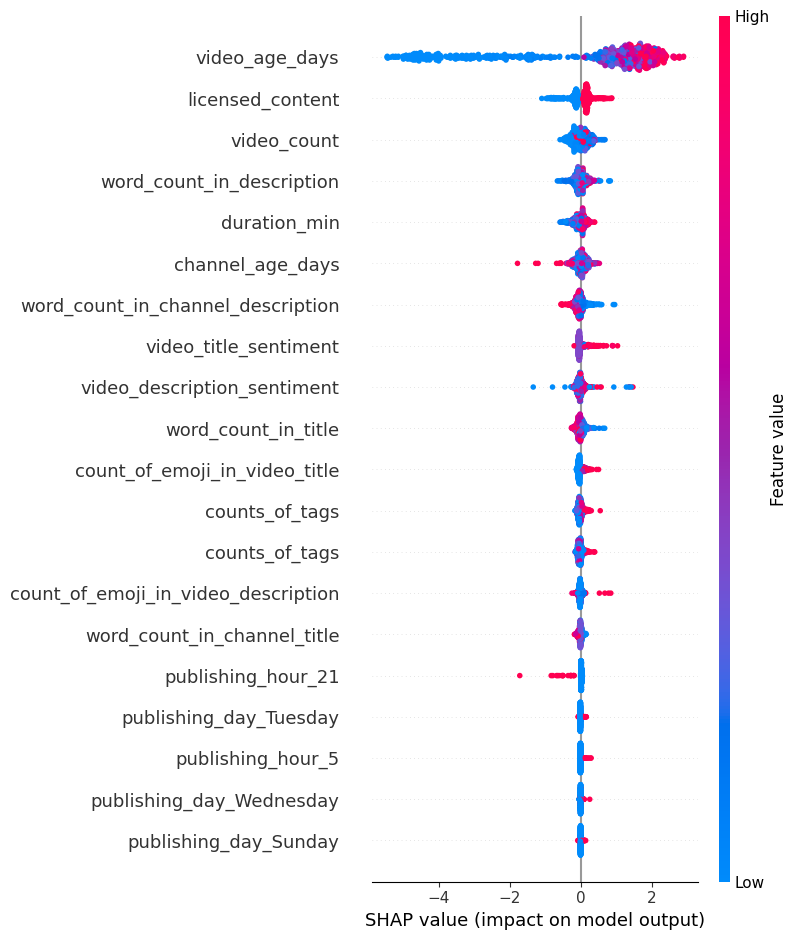

In [284]:
explainer = shap.Explainer(random_forest_model_engaging, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)      


In [336]:
X = df_model
y = df_output['subscriber_count'].apply(lambda x: np.log1p(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [338]:
X_train.columns

Index(['licensed_content', 'video_count', 'duration_min', 'is_high_definition',
       'counts_of_tags', 'video_title_sentiment',
       'count_of_emoji_in_video_title', 'video_description_sentiment',
       'count_of_emoji_in_video_description', 'video_age_days',
       'channel_age_days', 'counts_of_tags', 'word_count_in_title',
       'word_count_in_description', 'word_count_in_channel_title',
       'word_count_in_channel_description', 'publishing_day_Monday',
       'publishing_day_Saturday', 'publishing_day_Sunday',
       'publishing_day_Thursday', 'publishing_day_Tuesday',
       'publishing_day_Wednesday', 'publishing_hour_0', 'publishing_hour_1',
       'publishing_hour_2', 'publishing_hour_3', 'publishing_hour_4',
       'publishing_hour_5', 'publishing_hour_6', 'publishing_hour_7',
       'publishing_hour_8', 'publishing_hour_9', 'publishing_hour_10',
       'publishing_hour_11', 'publishing_hour_12', 'publishing_hour_13',
       'publishing_hour_14', 'publishing_hour_15', 

In [300]:
random_forest_model_subscriber = RandomForestRegressor(random_state=9)
random_forest_model_subscriber

RandomForestRegressor(random_state=9)

In [ ]:
train_model(model=random_forest_model_subscriber, X_train=X_train, y_train=y_train)

R^2: 0.8644038254589304
MAE: 0.9551204053673431
MSE: 1.9024912711663473
RMSE: 1.3793082582100158


/var/folders/kg/0rnyb9h57zjgz1rz383bzj380000gn/T/ipykernel_27858/3074047152.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10), palette='viridis' )


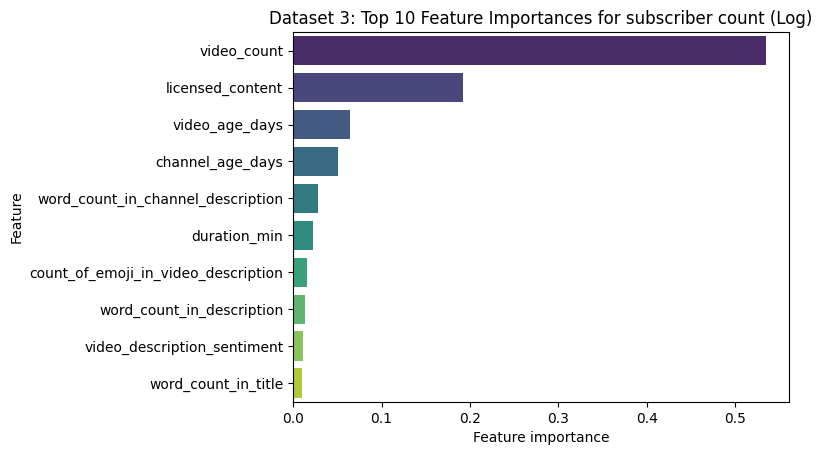

In [ ]:
feature_importance = random_forest_model_subscriber.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Feature importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10), palette='viridis' )
plt.title('Dataset 3: Top 10 Feature Importances for subscriber count (Log)')
plt.show()  


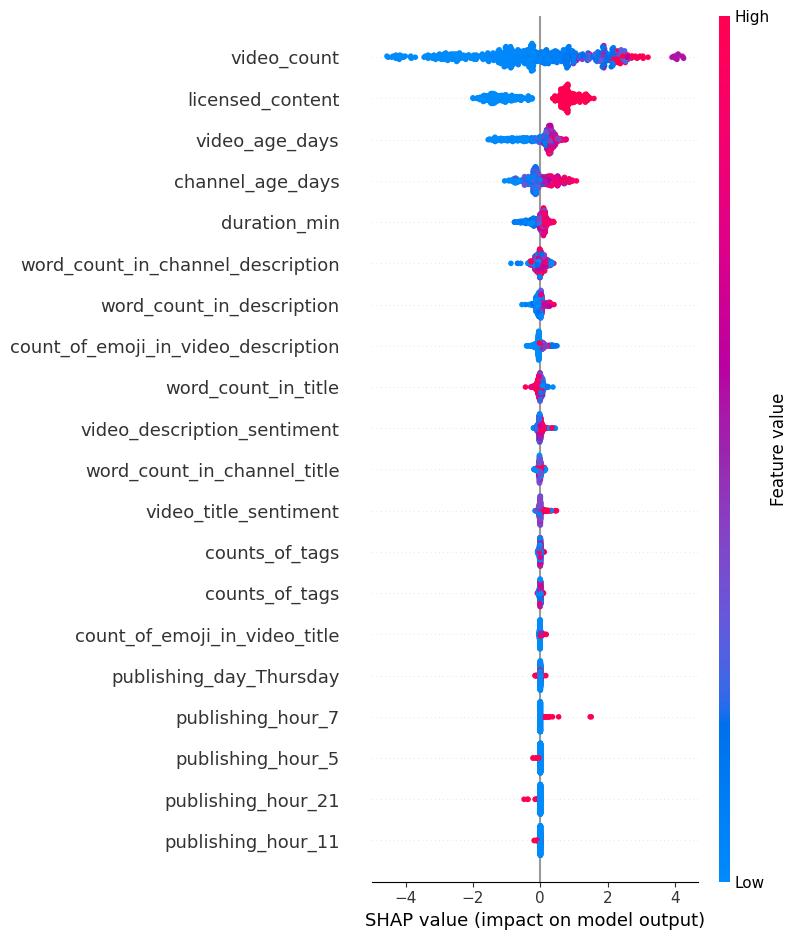

In [303]:

explainer = shap.Explainer(random_forest_model_subscriber, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.summary_plot(shap_values, X_train)      


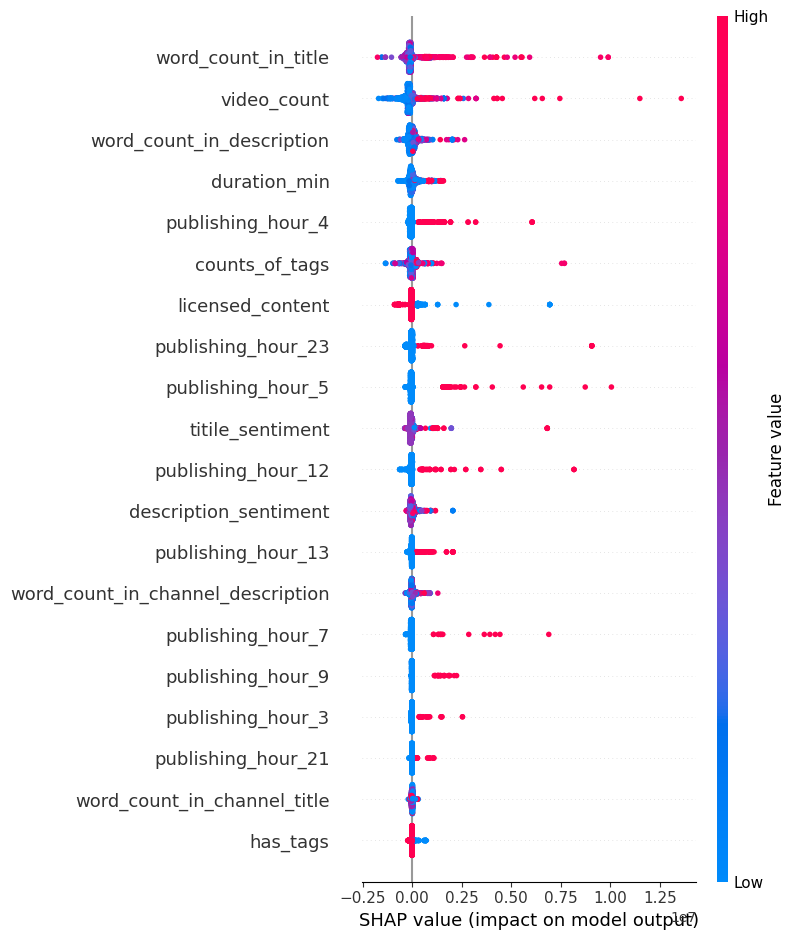

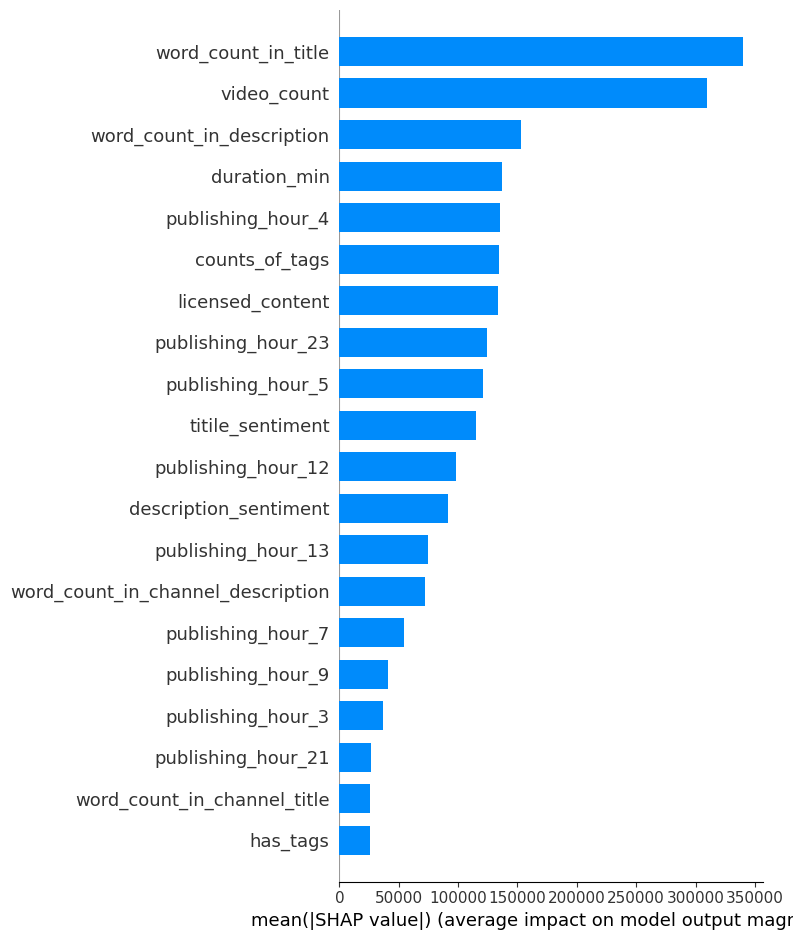

In [ ]:
explainer = shap.TreeExplainer(random_forest_model_view)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

In [376]:
X = df_model
y = df_output['video_view_count'].apply(lambda x: np.log1p(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, shuffle=True)



In [377]:
df_model.columns

Index(['licensed_content', 'video_count', 'duration_min', 'is_high_definition',
       'counts_of_tags', 'video_title_sentiment',
       'count_of_emoji_in_video_title', 'video_description_sentiment',
       'count_of_emoji_in_video_description', 'video_age_days',
       'channel_age_days', 'word_count_in_title', 'word_count_in_description',
       'word_count_in_channel_title', 'word_count_in_channel_description',
       'publishing_day_Monday', 'publishing_day_Saturday',
       'publishing_day_Sunday', 'publishing_day_Thursday',
       'publishing_day_Tuesday', 'publishing_day_Wednesday',
       'publishing_hour_0', 'publishing_hour_1', 'publishing_hour_2',
       'publishing_hour_3', 'publishing_hour_4', 'publishing_hour_5',
       'publishing_hour_6', 'publishing_hour_7', 'publishing_hour_8',
       'publishing_hour_9', 'publishing_hour_10', 'publishing_hour_11',
       'publishing_hour_12', 'publishing_hour_13', 'publishing_hour_14',
       'publishing_hour_15', 'publishing_hour_1

In [354]:
df.shape

(860, 71)

R^2: 0.593858745080295
MAE: 1.3633760798115164
MSE: 3.5171689554321772
RMSE: 1.8754116762546236


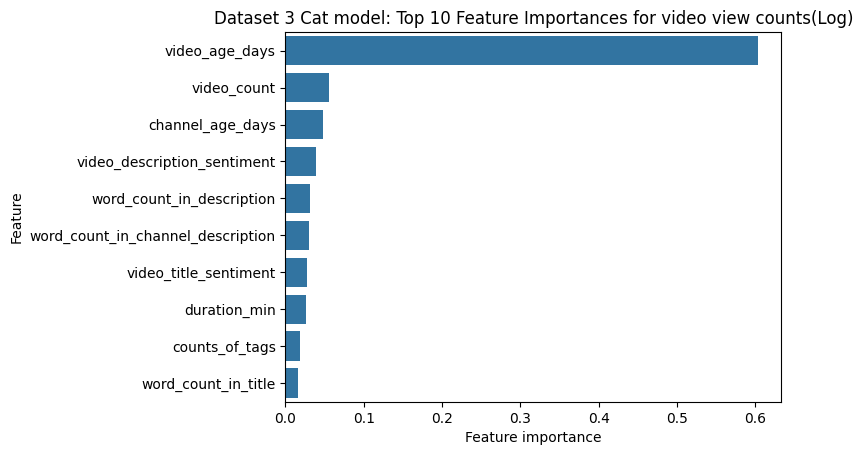

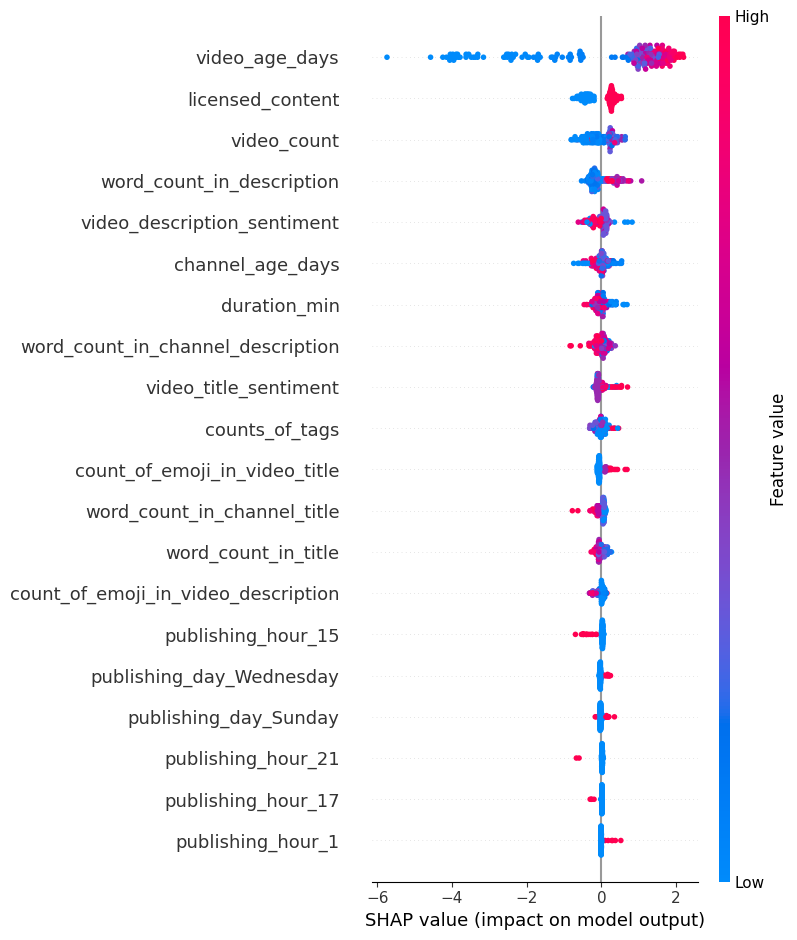

In [381]:
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)
cat_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=5,
                             eval_metric='R2',
                             l2_leaf_reg=5, 
                             random_seed=9,
                             logging_level='Silent'
                             )
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = cat_model.predict(test_pool)   
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  


feature_importances = cat_model.get_feature_importance(prettified=True)
feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10) )
plt.title('Dataset 3 Cat model: Top 10 Feature Importances for video view counts(Log)')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test,title='Dataset3: SHAP Feature Importance for Video view counts')  



In [344]:
X_train.columns

Index(['licensed_content', 'video_count', 'duration_min',
       'video_title_sentiment', 'video_description_sentiment',
       'video_age_days', 'channel_age_days', 'counts_of_tags',
       'word_count_in_title', 'word_count_in_description',
       'word_count_in_channel_title', 'word_count_in_channel_description',
       'publishing_day_Friday', 'publishing_day_Monday',
       'publishing_day_Saturday', 'publishing_day_Sunday',
       'publishing_day_Thursday', 'publishing_day_Tuesday',
       'publishing_day_Wednesday', 'publishing_hour_0', 'publishing_hour_1',
       'publishing_hour_2', 'publishing_hour_3', 'publishing_hour_4',
       'publishing_hour_5', 'publishing_hour_7', 'publishing_hour_8',
       'publishing_hour_9', 'publishing_hour_10', 'publishing_hour_11',
       'publishing_hour_12', 'publishing_hour_13', 'publishing_hour_14',
       'publishing_hour_15', 'publishing_hour_16', 'publishing_hour_17',
       'publishing_hour_18', 'publishing_hour_19', 'publishing_hour_20'

In [ ]:
feature_importance_df.columns

,Feature Id,Importances
0,video_age_days,47.056440
1,licensed_content,6.986460
2,word_count_in_description,5.274120
3,duration_min,4.771568
4,channel_age_days,4.040126
5,video_count,3.798478
6,word_count_in_channel_description,3.311400
7,video_title_sentiment,3.037351
8,channel_title,2.980825
9,counts_of_tags,2.848632


In [ ]:


small_sum = feature_importance_df[feature_importance_df['Importances'] < 0.1]['Importances'].sum()
print(f"Cumulative importance of small features: {small_sum}")

Cumulative importance of small features: 0.1864086062530285


In [339]:
X = df_catboost_model
y = df_output['engaging_count'].apply(lambda x: np.log1p(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, shuffle=True)



R^2: 0.6258251883460209
MAE: 1.3769634596664189
MSE: 3.6815918012284428
RMSE: 1.918747456344488


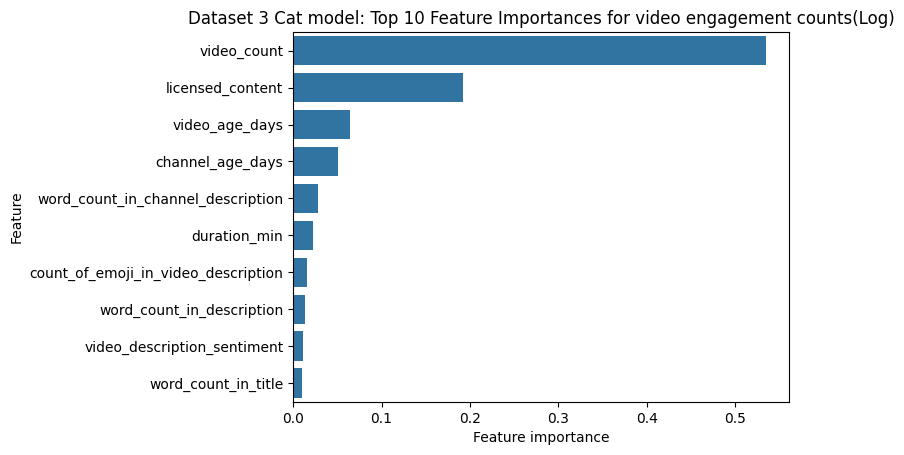

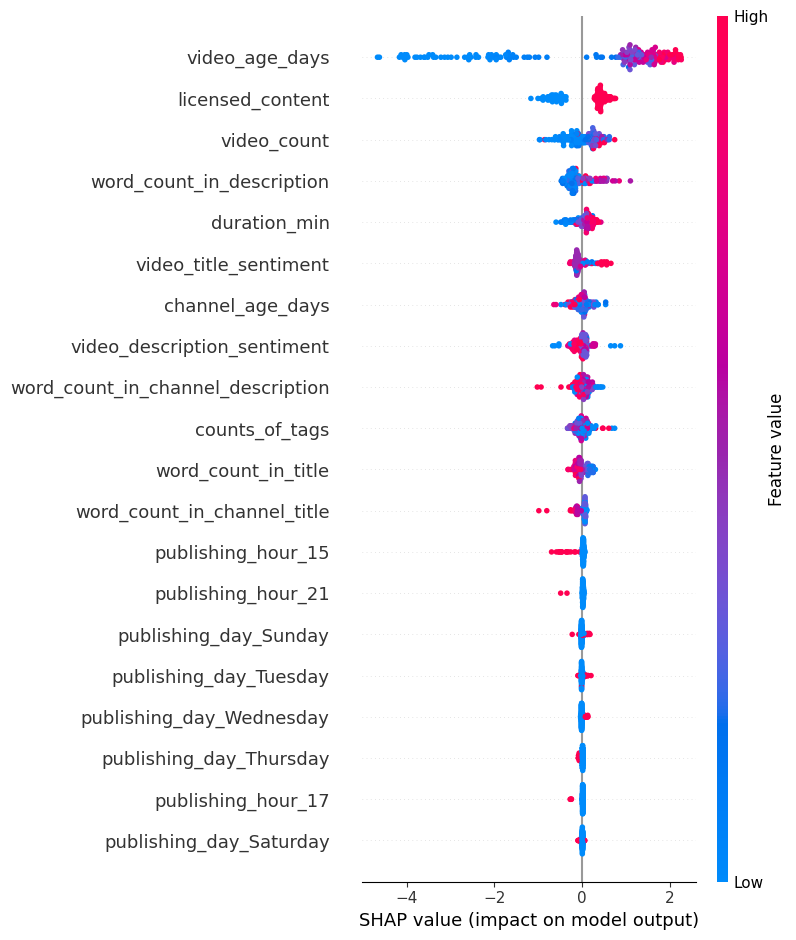

In [332]:

train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)
cat_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=5,
                             eval_metric='R2',
                             l2_leaf_reg=5, 
                             random_seed=9,
                             logging_level='Silent',
                             )
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = cat_model.predict(test_pool)   
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  


feature_importances = cat_model.get_feature_importance(prettified=True)
feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10) )
plt.title('Dataset 3 Cat model: Top 10 Feature Importances for video engagement counts(Log)')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test)   


In [334]:
X = df_catboost_model
y = df_output['subscriber_count'].apply(lambda x: np.log1p(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, shuffle=True)



R^2: 0.8676932163475004
MAE: 1.0037975324094877
MSE: 1.8563392504759462
RMSE: 1.3624754127968497


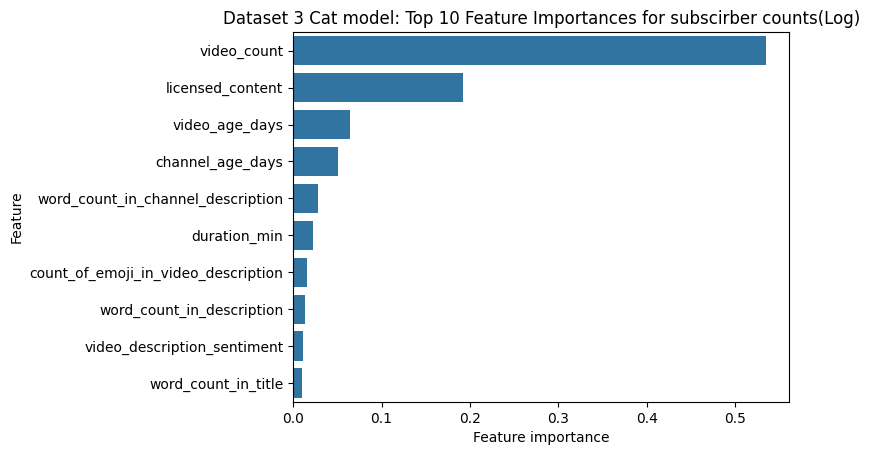

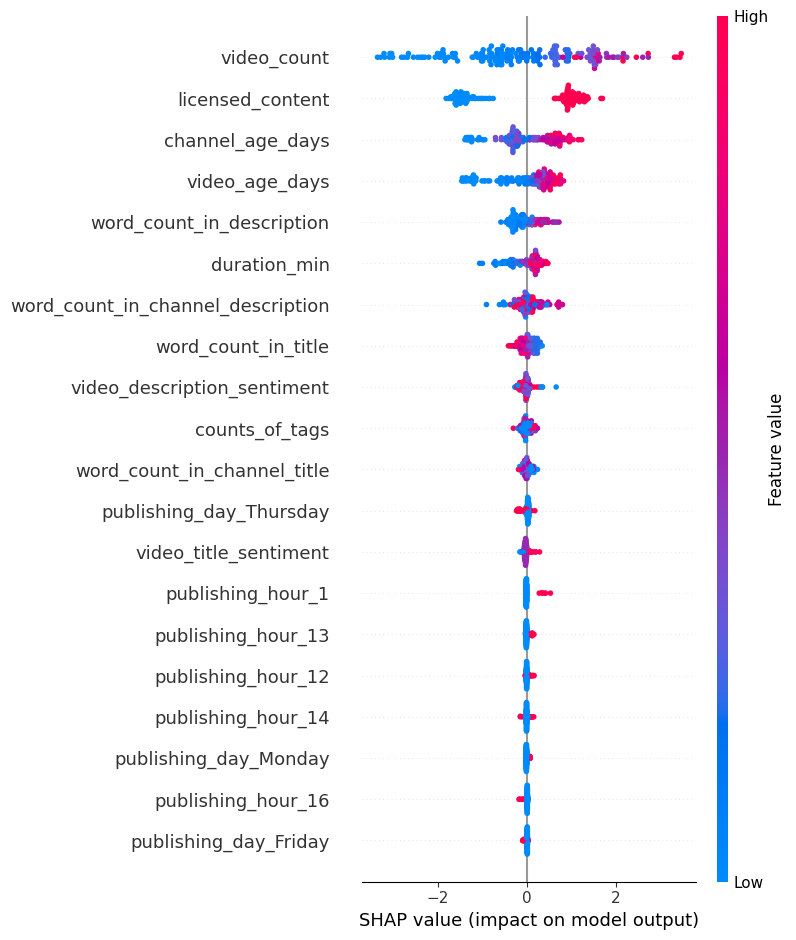

In [335]:

train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)
cat_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=5,
                             eval_metric='R2',
                             l2_leaf_reg=5, 
                             random_seed=9,
                             logging_level='Silent',
                             )
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = cat_model.predict(test_pool)   
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  


feature_importances = cat_model.get_feature_importance(prettified=True)
feature_importance_df = feature_importance_df.sort_values(by='Feature importance', ascending=False)
sns.barplot(x='Feature importance', y='Feature', data=feature_importance_df.head(10) )
plt.title('Dataset 3 Cat model: Top 10 Feature Importances for subscirber counts(Log)')
plt.show()

shap_values = cat_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:, :-1], X_test)   
